# VQEで水素分子の基底エネルギーを求める

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

VQE (variational quantum eigensolver; 変分量子固有値ソルバー)を使って実際の量子化学の問題を解いてみましょう。

VQEは2014年に発表された手法（[Peruzzo et al.](https://doi.org/10.1038/ncomms5213)）で、超伝導型量子コンピュータを使って水素分子などの小さい分子の基底状態エネルギーを求める問題に応用されたのは2017年の[Kandala et al.](https://doi.org/10.1038/nature23879)が始めてです。2017年というと量子コンピュータ業界においては太古の出来事ですが、それでも実際の学術論文の題材になった問題を実機で試すのは面白いのではないかと思います。

このコースは量子化学の講義ではないので、今回は問題のセットアップには深入りしません。幸い、Qiskit Nature（Qiskitの自然科学計算関連のモジュール）にいろいろなツールが組み込まれており、扱いたい分子の情報だけから量子コンピュータで期待値を測定すべき演算子を導出するところまでは自動でできます。この実習では、

- VQEを行うための変分量子回路を書く
- 渡された演算子の期待値を計算し、量子回路が作る量子状態のエネルギー期待値を計算する関数を書く
- Qiskit Runtimeを使って、実機での計算結果をもとにエネルギーを最小化するように変分回路のパラメータを調整していく

という部分を扱います。

In [1]:
import sys
sys.path.append('/home/jovyan/qc-workbook-lecturenotes')
import numpy as np
from qiskit import QuantumCircuit, IBMQ, Aer, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info.operators import Operator
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.ibmq import least_busy

from qc_workbook.utils import operational_backend
from qc_workbook.hamiltonian import make_hamiltonian
from qc_workbook.show_state import show_state
import qc_workbook.runtime_vqe

## （背景知識）水素分子を解くとは？

量子化学の背景とVQEとのつながりについての詳しい説明は、この実習の発想元になっている[今年のIBM Quantum Challengeのexercise 4](https://github.com/qiskit-community/ibm-quantum-spring-challenge-2022/blob/main/exercise4/04.quantum_chemistry.ipynb)（[日本語版](https://github.com/qiskit-community/ibm-quantum-spring-challenge-2022/blob/main/exercise4/04.quantum_chemistry-ja.ipynb)）が参考になります。ここでは最低限の説明をします。

今やりたいことは、ある分子の基本情報（構成する原子核種と数、電子の数、原子核の位置）を与えられた時に、その分子のエネルギー基底状態のエネルギー固有値を求めることです。ここで、原子核は電子に比べて遥かに重いことを利用し、原子核の位置を手で与えるパラメータとしています（Born-Oppenheimer approximation）。この基底状態エネルギーが求められれば、例えば今度は原子核の位置を動かしながら同じ計算を繰り返すことによって、最も基底状態エネルギーの低くなる原子核の配置（＝自然界で実現される分子のエネルギー基底状態の良い近似）を探すことなどができます。

### 分子軌道と$n$電子系の波動関数

原子単体に対しては、電子の軌道（エネルギー固有波動関数）$\{\chi_j(\mathbf{r})\}_j$とそれらに対応するエネルギーを、古典コンピュータでも精度良く計算することができます。さらに分子中の一電子軌道（Molecular orbital）$\phi_m(\mathbf{r})$も、分子を構成する原子における軌道の重ね合わせとして

$$
\phi_m(\mathbf{r}) = \sum_j D_{mj}\chi_j(\mathbf{r})
$$

のように表現できます。

理論的には原子軌道も分子軌道も無数に存在しますが、今の問題のような場合、固有エネルギーの高い軌道はほとんど影響を持たないので、有限個の$\phi_m$のみを扱います。また、電子にはスピンの自由度があり、内部に量子ビットのような二次元系を持ちますが、それも軌道の一部とみなしていいので（spin orbitals）、結局、固有エネルギーで順序づけして下から$2M$個の分子軌道を考えることになります。

一般に分子には複数の電子がありますが、パウリの排他律から、各軌道には最大1個の電子しか入りません。従って、$n$電子系の波動関数は$n$個の占有されている軌道の掛け算で表現されます。ただし、同じくパウリの排他律の帰結として、全系の波動関数は電子の交換について反対称になるので、単純な掛け算ではなくSlater行列式$| \phi_{m_1} \phi_{m_2} \dots \phi_{m_n} | (\mathbf{r}_1, \mathbf{r}_2, \dots, \mathbf{r}_n) $が用いられます。$n$電子系のエネルギー固有状態はこのSlater行列式の重ね合わせで

$$
\psi_{\text{elec}}(\mathbf{r}_1, \mathbf{r}_2, \dots,\mathbf{r}_n) = \sum_{m_1, m_2,\dots,m_n} C_{m_1, m_2, \dots, m_n} | \phi_{m_1}\phi_{m_2} \dots \phi_{m_n} | (\mathbf{r}_1, \mathbf{r}_2, \dots, \mathbf{r}_n)
$$

と書けるので、エネルギー固有状態や固有値を求めることは係数$C_{m_1, m_2, \dots, m_n}$を求めることに帰着します。ところが、軌道$\phi_m$が$2M$個あり、電子が$n$個あれば、系は$\binom{2M}{n}$次元となり、古典コンピュータでの計算はすぐに破綻してしまいます。そこで量子コンピュータの出番となるわけです。

### 第二量子化表現とJordan-Wigner変換

分子軌道の問題を量子コンピュータで扱う場合、系の状態を$n$体の波動関数$\psi_{\text{elec}}(\mathbf{r}_1, \mathbf{r}_2, \dots,\mathbf{r}_n)$で表現するよりも、$2M$個の軌道の占有・非占有で表現（第二量子化）する方が自然なマッピングとなります。その場合、ハミルトニアンは分子軌道ごとに定義される「生成・消滅演算子」$\hat{a}_m, \hat{a}_m^{\dagger}$を使って書かれ、

$$
\hat{H} =\sum_{r s} h_{r s} \hat{a}_{r}^{\dagger} \hat{a}_{s}
+\frac{1}{2} \sum_{p q r s} g_{p q r s} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}+E_{N}
$$

となります。ここで$h_{rs}$、$g_{pqrs}$、$E_N$は全て分子の構造から決まる（古典的に計算できる）定数で、それぞれ一電子のエネルギー、二電子間の電気的な反発のエネルギー、原子核同士の反発エネルギーに対応します。

生成・消滅演算子は、軌道$m$が占有されていない状態を$\ket{u}_m$、されている状態を$\ket{o}_m$とすると、

$$
\begin{align}
\hat{a}_m \ket{u}_m & = 0, \\
\hat{a}_m \ket{o}_m & = \ket{u}_m, \\
\hat{a}_m^{\dagger} \ket{u}_m & = \ket{o}_m, \\
\hat{a}_m^{\dagger} \ket{o}_m & = 0
\end{align}
$$

のように作用します。

このような占有・非占有の2次元系は、課題3のSchwingerモデルの問題にもあった通り、そのまま量子ビットに対応づけられます。つまり、$2M$個の軌道の状態を$2M$ビットの量子レジスタで表現できます。Schwingerモデルの問題ではサイトに粒子が存在する状態を$\ket{0}$、存在しない状態を$\ket{1}$に対応づけしましたが、今回はQiskitの習わしに従って、軌道が占有されている状態を$\ket{1}$、占有されていない状態を$\ket{0}$で表します。すると、$\hat{a}$と$\hat{a}^{\dagger}$はそれぞれ$\frac{1}{2}(X + iY)$と$\frac{1}{2}(X - iY)$に対応します。

$$
\begin{align}
\frac{1}{2}(X + iY) \ket{0} & = \frac{1}{2} (\ket{1} - \ket{1}) = 0, \\
\frac{1}{2}(X + iY) \ket{1} & = \frac{1}{2} (\ket{0} + \ket{0}) = \ket{0}, \\
\frac{1}{2}(X - iY) \ket{0} & = \frac{1}{2} (\ket{1} + \ket{1}) = \ket{1}, \\
\frac{1}{2}(X - iY) \ket{1} & = \frac{1}{2} (\ket{0} - \ket{0}) = 0.
\end{align}
$$

ただし、異なる軌道$j$と$k$の生成・消滅演算子が「反交換」しなければいけない（$a_r a_s = -a_s a_r$）という物理的要請があるので、実際には軌道$j$の生成・消滅演算子は

$$
\begin{align}
a_j \rightarrow I_{2M-1} \otimes I_{2M-2} \otimes \dots \otimes \frac{X_j + iY_j}{2} \otimes Z_{j-1} \otimes \dots \otimes Z_{0}, \\
a_j^{\dagger} \rightarrow I_{2M-1} \otimes I_{2M-2} \otimes \dots \otimes \frac{X_j - iY_j}{2} \otimes Z_{j-1} \otimes \dots \otimes Z_{0}
\end{align}
$$

のように、$j$より小さい軌道のスロットに$Z$演算子を挿入したような量子レジスタの演算に対応します。このような対応づけをJordan-Wigner変換といいます。実はSchwingerモデルの問題でも同じ操作をしていますが、説明を割愛していました。

Qiskit Natureのさまざまなクラスを利用すると、分子の核種と三次元位置を入力するだけで、ハミルトニアンの定数部分を計算し、生成・消滅演算子をJordan-Wigner変換して、ハミルトニアンをパウリ積（$X, Y, Z$ゲートと恒等演算$I$の組み合わせ）の和にしてくれます。

In [3]:
molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["H", [0.0, 0.0, -0.3695]],
        ["H", [0.0, 0.0, 0.3695]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule, # 分子の構成情報
    basis="sto3g", # 原子軌道の計算手法
    driver_type=ElectronicStructureDriverType.PYSCF, # 軌道計算用ライブラリ
)

properties = driver.run() # 分子のプロパティを計算

hamiltonian = properties.second_q_ops()[0] # そこから第二量子化ハミルトニアンを構築
print(hamiltonian)

Fermionic Operator
register length=4, number terms=14
  (0.18115454131173234+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18115454131173242+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18115454131173242+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18115454131173214+0j) * ( -_0 +_1 -_2 +_3  ...


上で`basis="sto3g"`で[STO-3G](https://en.wikipedia.org/wiki/STO-nG_basis_sets)という原子軌道の計算（展開）方法を指定しています。STO-3Gでは最低限必要な軌道しか計算に含まないので、$2M=2n$となり、水素分子の場合は$n=2$なので4分子軌道のハミルトニアンが導出されます。軌道の番号と実際の分子軌道との対応づけは

- $0$から$n-1$番軌道がスピン$\alpha$の軌道
- $n$から$2n-1$番軌道がスピン$\beta$の軌道

で、それぞれエネルギーの低い順に並んでいます。$\alpha$と$\beta$は、何か適当な方向を基底に決めた時のスピンの二つの固有状態を表します。

上のハミルトニアンのプリントアウトでは、例えば`+_0`は第0軌道の生成演算子、`-_3`は第3軌道の消滅演算子を表します。

次にこのハミルトニアンをJordan-Wigner変換し、パウリ積の和に落とし込みます。

In [5]:
converter = QubitConverter(JordanWignerMapper())

ham_op = converter.convert(hamiltonian)
print(ham_op)

0.04528863532793308 * YYYY
+ 0.04528863532793308 * XXYY
+ 0.04528863532793308 * YYXX
+ 0.04528863532793308 * XXXX
- 0.8118492064880125 * IIII
- 0.22389389642914398 * ZIII
+ 0.17156667591093255 * IZII
+ 0.12068268831019147 * ZZII
- 0.22389389642914392 * IIZI
+ 0.1744589329758667 * ZIZI
+ 0.16597132363812456 * IZZI
+ 0.17156667591093255 * IIIZ
+ 0.16597132363812456 * ZIIZ
+ 0.16873669065193606 * IZIZ
+ 0.12068268831019147 * IIZZ


得られるパウリ積は、一番左が第0軌道に対応するよう順序づけられています（2nビットレジスタの第2n-1ビットが第0軌道に、第0ビットが第2n-1軌道に対応します）。

我々の課題は、このハミルトニアンの期待値を最小化するような量子状態をつくる量子回路を探すことです。

## 量子計算部分

### 期待値の計算

量子コンピュータにおける観測量の期待値の計算方法については、課題1で軽く触れましたが、今回はより複雑な計算となるので、ステップを追って確認してみましょう。

#### $Z$の期待値

適当な1ビット量子回路で作られる量子状態での$Z$の期待値を計算しましょう。

量子コンピュータで観測量の期待値を計算するには、まず観測量を演算子で表し、その固有ベクトルと固有値を求め、量子回路の終状態に対して固有ベクトルが計算基底に移るような基底変換をし、測定の結果得られる計算基底の確率分布と固有値を掛け合わせるのでした。

今の場合、定義上、$Z$の固有ベクトルとは計算基底そのもので、固有値は$\pm 1$（$Z\ket{0} = \ket{0}, Z\ket{1} = -\ket{1}$）です。したがって、量子回路の終状態をそのまま測定し、0が出る確率$P_0$から1が出る確率$P_1$を引けば、$Z$の期待値が求まります。式で書けば

$$
\langle Z \rangle = P_0 - P_1
$$

です。

In [6]:
simulator = Aer.get_backend('qasm_simulator')
shots = 10000

In [2]:
# qc_workbookのmake_hamiltonianとqiskitとでパウリ積のノーテーション（特に順序）が異なるので、混乱を避けるためにラッパー関数を定義する

def compute_expval(circuit, paulis, coefficients=None):
    statevector = Operator(circuit).data[:, 0]
    observable = make_hamiltonian([p[::-1] for p in paulis], coeffs=coefficients)
    return (statevector.conjugate() @ observable @ statevector).real

In [7]:
# ランダムな1ビット回路
circuit = random_circuit(num_qubits=1, depth=3)

# 状態ベクトルから計算する厳密解
exact = compute_expval(circuit, ['z'])

expval_z = None

# circuitに測定を加え、simulatorで実行して、得られるカウントから期待値expval_zを計算してください。
##################
### EDIT BELOW ###
##################

circuit.measure_all()

circuit = transpile(circuit, backend=simulator)
counts = simulator.run(circuit, shots=shots).result().get_counts()

expval_z = (counts.get('0', 0) - counts.get('1', 0)) / shots

##################
### EDIT ABOVE ###
##################

print(f'QC: {expval_z}')
print(f'Exact: {exact}')

QC: 1.0
Exact: 1.0


上のセルを何度か実行してみて、毎回`expval_z`と`exact`が統計誤差の範囲で大体一致することを確認してください。

#### $X$の期待値

今度は基底変換が必要です。$X$の固有値$\pm 1$の固有ベクトルは$\frac{1}{\sqrt{2}} (\ket{0} \pm \ket{1})$なので、アダマールゲートで基底変換ができます。

In [8]:
# ランダムな1ビット回路
circuit = random_circuit(num_qubits=1, depth=3)

# 状態ベクトルから計算する厳密解
exact = compute_expval(circuit, ['x'])

expval_x = None

# circuitに基底変換と測定を加え、simulatorで実行して、得られるカウントから期待値expval_xを計算してください。
##################
### EDIT BELOW ###
##################

circuit.h(0)
circuit.measure_all()

circuit = transpile(circuit, backend=simulator)
counts = simulator.run(circuit, shots=shots).result().get_counts()

expval_x = (counts.get('0', 0) - counts.get('1', 0)) / shots

##################
### EDIT ABOVE ###
##################

print(f'QC: {expval_x}')
print(f'Exact: {exact}')

QC: 0.1756
Exact: 0.18859155814402295


#### $Y$の期待値

$Y$の固有ベクトルは$\frac{1}{\sqrt{2}}(\ket{0} \pm i\ket{1})$なので、$S^{\dagger} = P(-\pi/2)$とアダマールゲートで基底変換ができます。$S^{\dagger}$ゲートのqiskitでの記法は`circuit.sdg(0)`です。

In [9]:
# ランダムな1ビット回路
circuit = random_circuit(num_qubits=1, depth=3)

# 状態ベクトルから計算する厳密解
exact = compute_expval(circuit, ['y'])

expval_y = None

# circuitに基底変換と測定を加え、simulatorで実行して、得られるカウントから期待値expval_yを計算してください。
##################
### EDIT BELOW ###
##################

circuit.sdg(0)
circuit.h(0)
circuit.measure_all()

circuit = transpile(circuit, backend=simulator)
counts = simulator.run(circuit, shots=shots).result().get_counts()

expval_y = (counts.get('0', 0) - counts.get('1', 0)) / shots

##################
### EDIT ABOVE ###
##################

print(f'QC: {expval_y}')
print(f'Exact: {exact}')

QC: -0.9388
Exact: -0.9309746674057489


#### $I$の期待値

恒等演算子を観測量としたとき、その期待値はいくらになるでしょうか？

#### $ZIZI$の期待値

今度は4ビットの回路で観測量$ZIZI$の期待値を計算します。固有値と固有ベクトルはどうなっているでしょうか？基底変換は必要でしょうか？

In [10]:
# ランダムな4ビット回路
circuit = random_circuit(num_qubits=4, depth=5)

# 状態ベクトルから計算する厳密解
exact = compute_expval(circuit, ['zizi'])

expval_zizi = None

# circuitを使って期待値expval_ziziを計算してください。
##################
### EDIT BELOW ###
##################

circuit.measure_all()

circuit = transpile(circuit, backend=simulator)
counts = simulator.run(circuit, shots=shots).result().get_counts()

expval_zizi = 0.
for key, value in counts.items():
    sign = 1.
    if key[0] == '1':
        sign *= -1.
    if key[2] == '1':
        sign *= -1.
        
    expval_zizi += sign * value

expval_zizi /= shots

##################
### EDIT ABOVE ###
##################

print(f'QC: {expval_zizi}')
print(f'Exact: {exact}')

QC: 0.4998
Exact: 0.4959938483841807


#### $ZIZI + 2IZII + 3XXYY$の期待値

今度の観測量はパウリ積の和です。量子回路ではこれを一度に計算することができませんが、和の期待値は期待値の和なので、それぞれの項について独立に期待値を計算し、最後に係数をかけて足し合わせれば同じ答えが得られます。量子回路はいくつ必要でしょうか？

In [11]:
# ランダムな4ビット回路
circuit = random_circuit(num_qubits=4, depth=5)

# 状態ベクトルから計算する厳密解
exact = compute_expval(circuit, ['zizi', 'izii', 'xxyy'], [1., 2., 3.])

expval_paulisum = None

# circuitを使って期待値expval_paulisumを計算してください。
##################
### EDIT BELOW ###
##################

circuit1 = circuit.copy()

circuit1.measure_all()

circuit1 = transpile(circuit1, backend=simulator)
counts = simulator.run(circuit1, shots=shots).result().get_counts()

expval_zizi = 0.
expval_izii = 0.
for key, value in counts.items():
    sign_zizi = 1.
    sign_izii = 1.
    if key[0] == '1':
        sign_zizi *= -1.
    if key[1] == '1':
        sign_izii *= -1.
    if key[2] == '1':
        sign_zizi *= -1.
        
    expval_zizi += sign_zizi * value
    expval_izii += sign_izii * value

expval_zizi /= shots
expval_izii /= shots

circuit2 = circuit.copy()

circuit2.sdg([0, 1])
circuit2.h(range(4))
circuit2.measure_all()

circuit2 = transpile(circuit2, backend=simulator)
counts = simulator.run(circuit2, shots=shots).result().get_counts()

expval_xxyy = 0.
for key, value in counts.items():
    parity = key.count('1') % 2
    sign = 2. * parity - 1.
    
    expval_xxyy += sign * value

expval_xxyy /= shots

expval_paulisum = expval_zizi + 2. * expval_izii + 3. * expval_xxyy

##################
### EDIT ABOVE ###
##################

print(f'QC: {expval_paulisum}')
print(f'Exact: {exact}')

QC: 2.9664
Exact: 3.0


#### 水素分子ハミルトニアンの期待値

上の`ham_op`の期待値を、適当な4ビット回路について計算しましょう。

In [12]:
# ランダムな4ビット回路
circuit = random_circuit(num_qubits=4, depth=5)

# 状態ベクトルから計算する厳密解
exact = compute_expval(circuit, ham_op.primitive.paulis.to_labels(), ham_op.coeffs.real)

# 水素分子の計算は後で再利用するので関数化しておく
def energy_expval(circuit, hamiltonian_op, backend, shots=2000):
    energy = 0.
    
    # circuitを使って期待値energyを計算してください。
    # hamiltonian_opはパウリ積とそれぞれにかかる係数からなるので、その一つ一つについて期待値を求め、
    # 係数をかけてenergyに足し合わせていきます。つまり、
    # 
    # for pauli_term in hamiltonian_op:
    #    # paulisがXXYYやIZIZなどのパウリ積を表す文字列
    #    paulis = pauli_term.primitive.paulis.to_labels()[0]
    #    # coefficientがこの項の係数
    #    coefficient = pauli_term.coeffs[0].real
    #
    #    expval = ...
    #
    #    energy += expval * coefficient
    #
    # のようなループを書くことになります。
    
    ##################
    ### EDIT BELOW ###
    ##################

    circuit_iz = circuit.copy()
    circuit_iz.measure_all()

    circuit_iz = transpile(circuit_iz, backend=backend)
    counts_iz = backend.run(circuit_iz, shots=shots).result().get_counts()

    energy = 0.

    for pauli_term in hamiltonian_op:
        # paulisがXXYYやIZIZなどのパウリ積を表す文字列
        paulis = pauli_term.primitive.paulis.to_labels()[0]
        # coefficientがこの項の係数
        coefficient = pauli_term.coeffs[0].real

        if 'X' in paulis or 'Y' in paulis:
            circ = circuit.copy()

            for iq, label in enumerate(paulis[::-1]):
                if label == 'X':
                    circ.h(iq)
                elif label == 'Y':
                    circ.sdg(iq)
                    circ.h(iq)

            circ.measure_all()

            circ = transpile(circ, backend=backend)
            counts = backend.run(circ, shots=shots).result().get_counts()

        else:
            counts = counts_iz

        expval = 0.
        for key, value in counts.items():
            sign = 1.
            for bit, label in zip(key, paulis):
                if bit == '1' and label != 'I':
                    sign *= -1.

            expval += sign * value

        expval /= shots

        energy += coefficient * expval

    ##################
    ### EDIT ABOVE ###
    ##################
    
    return energy


print(f'QC: {energy_expval(circuit, ham_op, simulator)}')
print(f'Exact: {exact}')

QC: -1.343475129090122
Exact: -1.329396347663856


### 変分量子回路の設計と実装

回路とハミルトニアンが与えられた時にエネルギーを計算する手法が確立できたので、次は最低エネルギー状態を作る回路を構成することを考えます。もちろん、そんな回路が最初からわかっているわけではないので、代わりに適当なパラメータつき量子回路を設計し、その回路におけるエネルギー期待値が最も小さくなるようにパラメータの値を更新していく、つまり変分量子回路の手法を使います。

まず、近似的な低エネルギー状態を作ります。「あたり」をつけてからパラメータ付き回路部分で微調整をするようにすることで、解の探索を速くできます。

最低エネルギー状態の第0近似はいわゆるHartree-Fock状態、つまり電子が軌道を下から占有した状態です。今の場合、一番エネルギーの低い軌道は$\phi_0$と$\phi_2$（$\alpha$と$\beta$スピンの最低エネルギー軌道）なので、

$$
\psi_{\mathrm{HF}} = |\phi_0 \phi_2|.
$$

Jordan-Wigner変換で対応づけた量子レジスタで表すと

$$
\ket{\psi_{\mathrm{HF}}} = \ket{1010}
$$

となります。

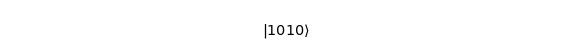

In [13]:
hf_circuit = QuantumCircuit(4)

# hf_circuitを|0000>からHartree-Fock状態|1010>を作る回路にしてください。量子ビットは右から数えることに注意。
##################
### EDIT BELOW ###
##################

hf_circuit.x(1)
hf_circuit.x(3)

##################
### EDIT ABOVE ###
##################

show_state(hf_circuit, state_label=None, binary=True);

パラメータ付き回路部分の設計には最先端の理論に基づく後ろ盾と勘が必要ですが、今は手始めに業界でTwoLocalなどと呼ばれるパターンを使いましょう。

In [14]:
from IPython.display import Image

Image(url='figs/twolocal.png', width=600)

上のような回路を1レイヤーとして、2レイヤー繰り返します。全ての$R_y$と$R_z$ゲートに独立なパラメータをあてがうので、全部で16個の自由パラメータを持つ回路になります。

回路に自由パラメータを入れる方法として、Qiskitには`Parameter`（単一のパラメータ）や`ParameterVector`（パラメータの配列）という仕組みが備わっています。下では`theta`という`ParameterVector`を定義し、`ry`や`rz`ゲートの回転角に使います。

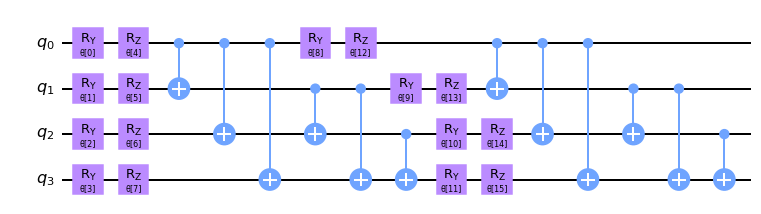

In [15]:
theta = ParameterVector('θ', 16)

param_circuit = QuantumCircuit(4)

# param_circuitを上で図示したTwoLocalレイヤーを3回繰り返す回路にしてください。
# thetaは通常の配列のように参照できるので、例えば第5要素をビット1のRzゲートに使うときは
#   param_circuit.ry(theta[5], 1)
# と書きます。
##################
### EDIT BELOW ###
##################

iparam = 0

for _ in range(2):
    for iq in range(4):
        param_circuit.ry(theta[iparam], iq)
        iparam += 1

    for iq in range(4):    
        param_circuit.rz(theta[iparam], iq)
        iparam += 1

    param_circuit.cx(0, 1)
    param_circuit.cx(0, 2)
    param_circuit.cx(0, 3)
    param_circuit.cx(1, 2)
    param_circuit.cx(1, 3)
    param_circuit.cx(2, 3)
    
##################
### EDIT ABOVE ###
##################

param_circuit.draw('mpl')

最後に基底状態の近似とパラメータ付き回路を組み合わせてアンザッツとします。

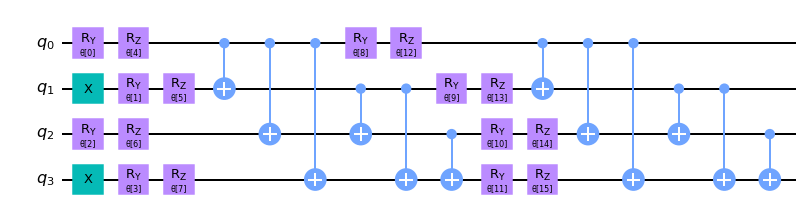

In [16]:
ansatz = hf_circuit.compose(param_circuit, inplace=False)
ansatz.draw('mpl')

アンザッツにパラメータの具体値を代入するときは`bind_parameters`関数を使います。

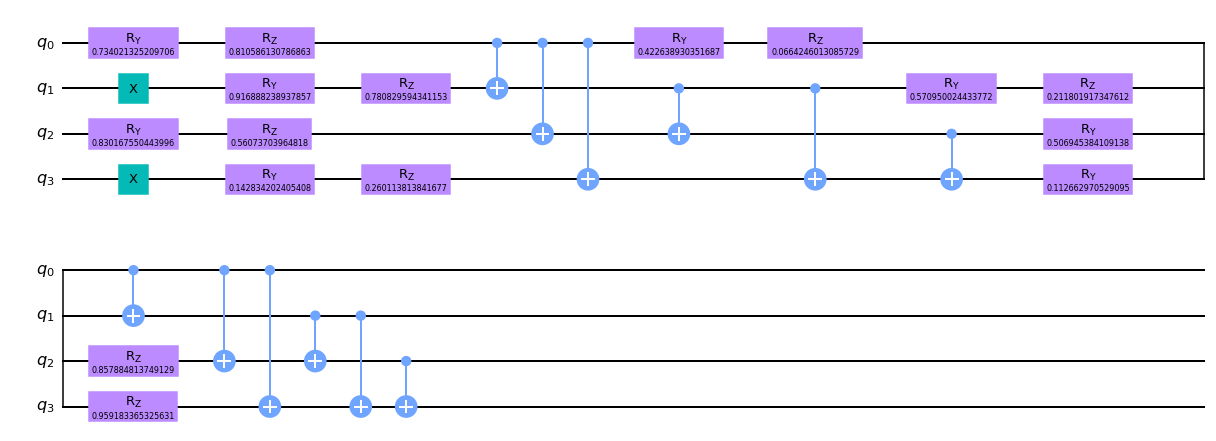

In [17]:
param_values = np.random.random(ansatz.num_parameters)
concrete_circuit = ansatz.bind_parameters(param_values)
concrete_circuit.draw('mpl')

これまでのコードを組み合わせて、パラメータの値の配列を引数として、上のTwoLocalアンザッツでの水素分子ハミルトニアンの期待値を返す関数を書きましょう。`ham_op`や`ansatz`といった変数は関数の中でそのまま使えます。

In [18]:
def objective_function(param_values):
    energy = 0.
    
    ##################
    ### EDIT BELOW ###
    ##################
    
    circuit = ansatz.bind_parameters(param_values)
    
    energy = energy_expval(circuit, ham_op, simulator)
    
    ##################
    ### EDIT ABOVE ###
    ##################
    
    return energy

# θ[11]をπにし、残りの全てのパラメータを0にすると、アンザッツの構造からHartree-Fock状態|1010>を回復できる
test_values = np.zeros(ansatz.num_parameters)
test_values[11] = np.pi

print(f'Objective function with test values: {objective_function(test_values)}')
print(f'Energy of the Hartree-Fock state: {energy_expval(hf_circuit, ham_op, simulator)}')

Objective function with test values: -0.2466927530852072
Energy of the Hartree-Fock state: -0.25063286435873744


## Qiskit Runtime

ここまでできたら、qc_workbook/runtime_vqe.pyというファイルを開き、アンザッツとハミルトニアン（とその他色々）を引数に取り、ハミルトニアンの期待値を最小化するアンザッツのパラメータの値をCOBYLAで探す`main`という関数を実装してください。

Qiskit Runtimeは、Qiskitを使った量子計算プログラムを一つのジョブとしてIBM Cloud上で実行するフレームワークです。プログラム全体で一つのジョブなので、プログラム実行中は指定した量子コンピュータバックエンドを占有できます。つまりプログラム中で量子コンピュータのバックエンドに回路を投げると、その量子計算「ジョブ」はキューに入ることなくほぼリアルタイムに実行され、計算が終わり次第結果を返します。Runtimeを使うとVQEのような量子・古典ハイブリッドの逐次計算が効率よくできます。

量子計算プログラムは単一のPythonファイルとしてIBM側にアップロードします。Pythonファイル中のmainという関数がクラウド上で実行され、関数の返り値がプログラムジョブの実行結果として返ってきます。

まずは`main`が正しく実装できたか、ローカルに試してみましょう。`qc_workbook.runtime_vqe`を普通のPythonモジュールとしてインポートし、`main`を実行します。

In [19]:
# autoreloadを使うと、インポートしたファイルを編集したときにIPythonカーネルの再起動なしに再インポートできる
%load_ext autoreload
%autoreload 1
%aimport qc_workbook.runtime_vqe

`main`の二個目の引数はジョブの実行中に途中経過をユーザーに教えてくれるUserMessengerオブジェクトで、クラウドで実行するときにはIBM側でインスタンスが用意されます。ただし、`publish`というメソッドが定義されているオブジェクトであればなんでもいいので、ここでは自前に簡易的な物を作り、`main`に渡します。

In [26]:
class LocalUserMessenger:
    # このクラスは後で使い回すので、今は使わないjob_idという引数も定義されています
    def publish(self, interim_result, job_id=None):
        print('**-------------------------------------------------------**')
        if job_id:
            print(f'{time.strftime("%Y-%m-%d %H:%M:%S")}: From job {job_id}')
            
        print(f'  Parameter values (first 4): {interim_result["params"][:4]}')
        print(f'  Current energy: {interim_result["energy"]} Ha')
        print(f'  Number of function calls: {interim_result["num_calls"]}')

一個目の引数としてqasm_simulatorを渡し、関数を実行します。

In [27]:
result = qc_workbook.runtime_vqe.main(simulator, LocalUserMessenger(), ansatz, ham_op, maxiter=150, tol=None, shots=4000)

print('**-----------------------------------------------------------------------------------**')
print(f'Energy found with VQE: {result["energy"]:.3f} Ha (COBYLA {result["num_calls"]} calls)')
print(f'Exact ground-state energy: -1.853 Ha')

**-------------------------------------------------------**
  Parameter values (first 4): [1.01 0.01 1.01 0.01]
  Current energy: -0.8762301003938036 Ha
  Number of function calls: 10
**-------------------------------------------------------**
  Parameter values (first 4): [ 1.50286738 -0.51561911  1.38890379 -0.38194216]
  Current energy: -1.0810448005574516 Ha
  Number of function calls: 20
**-------------------------------------------------------**
  Parameter values (first 4): [ 2.03801646 -0.25761294 -0.03063066 -0.46052184]
  Current energy: -1.1339328794582628 Ha
  Number of function calls: 30
**-------------------------------------------------------**
  Parameter values (first 4): [ 1.23678801 -0.6464809   0.49311281 -0.48029414]
  Current energy: -1.1685353638909444 Ha
  Number of function calls: 40
**-------------------------------------------------------**
  Parameter values (first 4): [ 1.54889684 -0.48954924 -0.29456983 -0.81350639]
  Current energy: -1.2455755764853325 Ha

厳密解に大体近い値が得られていれば成功です。時々-1.24あたりで局所解にひっかかってしまうことがあるようなので、二回程度試してみるといいかもしれません。

プログラムが書けたら、最後にそれをアップロードしてクラウドで実行してみましょう。

もしも登録漏れなどで`ibm-q-utokyo/internal/qc-training22`プロバイダが使えない場合は、残念ながらここから先は実行できません。（`open`プロバイダではプログラムのアップロードが許可されていないので）

In [28]:
# まずはいつものおまじないでproviderを定義

IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='qc-training22')

In [30]:
# プログラムファイルの場所
program_path = qc_workbook.runtime_vqe.__file__

# プログラムに付随するメタデータ

json_schema = 'https://json-schema.org/draft/2019-09/schema'

metadata = {
    'name': 'simple-vqe',
    'description': 'Simple VQE.',
    'max_execution_time': 14400,
    'spec': {
        'backend_requirements': {'min_num_qubits': 2},
        'parameters': {
            '$schema': json_schema,
            'type': 'object',
            'properties': {
                'ansatz': {'description': 'Ansatz QuantumCircuit.', 'type': 'object'},
                'hamiltonian_op': {'description': 'A PauliSumOp representing the Hamiltonian of the problem.', 'type': 'object'},
                'initial': {'description': 'Initial values of the free parameters of the ansatz.', 'type': 'array'},
                'shots': {'description': 'Number of shots for each QuantumCircuit to evaluate.', 'type': 'number'},
                'maxiter': {'description': 'Maximum number of COBYLA iterations.', 'type': 'number'},
                'tol': {'description': 'Tolerance parameter for the COBYLA optimizer.', 'type': 'number'},
                'report_every': {'description': 'If >0, number of objective function calls to make before sending an interim result.', 'type': 'number'}
            },
            'required': ['ansatz', 'hamiltonian_op']
        },
        'return_values': {'$schema': json_schema, 'description': 'Counts', 'type': 'string'},
        'interim_results': {
            '$schema': json_schema,
            'type': 'object',
            'properties': {
                'params': {'description': 'Current parameter values.', 'type': 'array'},
                'energy': {'description': 'Current energy.', 'type': 'number'},
                'total_call': {'description': 'Number of calls to the objective function made so far.', 'type': 'number'},
                'total_shots': {'description': 'Number of shots used so far.', 'type': 'number'}
            }
        }
    }
}

# プログラムをアップロードし、IDを取得
program_id = provider.runtime.upload_program(data=program_path, metadata=metadata)
    
print(program_id)

simple-vqe-9ZJQGjM9b1


プログラムは一度アップロードすれば何回でも使えるので、上で表示されたIDを記録しておいてください。

アップロードしたプログラムの一覧は[IBM QuantumのServicesページ](https://quantum-computing.ibm.com/services?services=runtime)で見ることができます。simple-vqeというパネルがあれば、アップロード成功です。パネルをクリックするとプログラムIDも確認することができます。

それでは今度は[クラウド上のシミュレータ](https://quantum-computing.ibm.com/services?services=simulators&system=ibmq_qasm_simulator)をバックエンドとしてこのプログラムを実行しましょう。

In [35]:
# 前述したクラウド上のUserMessengerはpublish()が呼ばれる度にユーザーと通信をし、publish()の引数を送ってくるので、それを受け取ってローカルで処理（印字するなど）する関数を定義します
def callback_fn(job_id, interim_result):
    LocalUserMessenger().publish(interim_result, job_id)

In [32]:
# mainの3個目以降の引数
inputs = {
    'ansatz': ansatz,
    'hamiltonian_op': ham_op,
    'maxiter': 40,
    'shots': 4000,
    'report_every': 20
}

simulator_job = provider.runtime.run(program_id=program_id, # program_idで指定したプログラムを実行
                                     options={'backend_name': 'ibmq_qasm_simulator'}, # バックエンドとしてibmq_qasm_simulatorを利用
                                     inputs=inputs, # 関数の引数
                                     callback=callback_fn) # user_messenger.publish()から送られてくる情報の処理をする関数

runtime_job._stream_results:WARNING:2022-06-15 14:36:38,435: An error occurred while streaming results for job cakmvlr762hnc4c6kk80:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 357, in _stream_results
    user_callback(self.job_id(), _decoder.decode(response))
  File "/tmp/ipykernel_6519/3562115929.py", line 3, in callback_fn
    LocalMessenger().publish(interim_result, job_id)
NameError: name 'LocalMessenger' is not defined

runtime_job._stream_results:WARNING:2022-06-15 14:36:44,938: An error occurred while streaming results for job cakmvlr762hnc4c6kk80:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 357, in _stream_results
    user_callback(self.job_id(), _decoder.decode(response))
  File "/tmp/ipykernel_6519/3562115929.py", line 3, in callback_fn
    LocalMessenger().publish(interim_result, job_id)
NameError

In [33]:
final_result = simulator_job.result()
print('Final result:')
LocalUserMessenger().publish(final_result)

Final result:
**-------------------------------------------------------**
  Parameter values (first 4): [ 2.23968236 -1.51406285  1.53774356 -1.60701473]
  Current energy: -1.8240199282054732 Ha
  Number of function calls: 151


シミュレータでの実行もうまくいけば、いよいよ実機を使います。

In [34]:
base_filter = operational_backend(min_qubits=4)
# belemの挙動が数日前からおかしいので、除いておく
filters = lambda b: base_filter(b) and b.name() != 'ibmq_belem'

backend_list = provider.backends(filters=filters)
# 今一番空いているバックエンド
backend = least_busy(backend_list)
print(backend.name())

ibm_hanoi


In [36]:
job = provider.runtime.run(program_id=program_id,
                           options={'backend_name': backend.name()},
                           inputs=inputs,
                           callback=callback_fn)

In [37]:
final_result = job.result()
print(f'Final result with {backend.name()}:')
LocalUserMessenger().publish(final_result)

Final result with ibm_hanoi:


KeyboardInterrupt: 

結果はあまり厳密解に近くないかもしれません。

ただし、今回はいつものように「これだからNISQは」で片付けて諦めなくてもいいかもしれません。すでに2017年のハードウェアで比較的まともな結果が得られているわけですから。

2017年のペーパーでは量子計算部分を極力効率化しています。おそらく最も効いているのは、分子軌道の基底を変換して実行的に二軌道の問題に直し、2量子ビット回路で問題を解いていることですが、今の4量子ビットのままでもアンザッツの工夫などでもっと良い結果が得られるはずです。是非自分で色々なアイディアを試してみてください。

ヒントとして、比較的に取り組みやすい改善法を挙げておきます。

- 今のアンザッツは電子数を保存しない（アンザッツが作る状態に"1"が2個でない計算基底も重ね合わさっている）が、水素分子のエネルギー固有ベクトルは電子2つの計算基底で張られる部分空間にあるはずである。パラメータ付き回路の構造を変えて、状態が任意のパラメータの値について$c_3 \ket{0011} + c_5 \ket{0101} + c_6 \ket{0110} + c_9 \ket{1001} + c_{10} \ket{1010} + c_{12} \ket{1100}$となるようにしてみる。
- アンザッツのCNOTの数を減らす。つまりCNOTが隣接量子ビット同士にのみかかるようにし、SWAPができるだけ起こらないようにする。
- 測定エラー緩和を導入する。
